In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import defaultdict

In [2]:
def utility_function(risk_factor, portfolio_return):
    value = ((1 + portfolio_return)**(1-risk_factor))/(1-risk_factor)
    return value

## Optimization formula:
## $\underset{\theta}{\max} \frac{1}{T} \sum^{T-1}_{t=0} u\left( \sum_{i=1}^{N_{t}}( \bar{w}_{i,t} + \frac{1}{N_{t}}\theta^{\text{T}} \hat{x}_{i,t} ) r_{i,t+1} \right) $

## Critical point of formula:

## $ \frac{1}{T} \sum^{T-1}_{t=0} u'(r_{p,t+1}) \frac{1}{N_{t}}\hat{x}_{t}^{\text{T}} r_{t+1} = 0 $


## Utility function

## $u(r_{p,t+1}) = \frac{(1+r_{p,t+1})^{1-\gamma}}{1-\gamma} $

## Portfolio return
## $ r_{p,t+1} = \sum^{N_{t}}_{i=1} \bar{w}_{i,t} r_{i,t+1} + \sum^{N_{t}}_{i=1} (  \frac{1}{N_{t}} \theta^{\text{T}} \hat{x}_{i,t} ) r_{i,t+1} $


## Utility function derivate

## $u'(r_{p,t+1}) = (1+r_{p, t+1})^{-\gamma} r'_{p, t+1} $

## Portfolio return derivate
## $ r'_{p,t+1} = \sum^{N_{t}}_{i=1} (  \frac{1}{N_{t}} \hat{x}_{i,t} ) r_{i,t+1} = \frac{1}{N_{t}}\hat{x}_{t}^{\text{T}} r_{t+1} $

## Critical point expanded:
## $ \frac{1}{T} \sum^{T-1}_{t=0} u'(r_{p,t+1}) \frac{1}{N_{t}}\hat{x}_{t}^{\text{T}} r_{t+1} = 0 $
## $ \frac{1}{T} \sum^{T-1}_{t=0} (1+r_{p, t+1})^{-\gamma} r'_{p, t+1} \frac{1}{N_{t}}\hat{x}_{t}^{\text{T}} r_{t+1} = 0 $
## $ \frac{1}{T} \sum^{T-1}_{t=0} (1+r_{p, t+1})^{-\gamma} (r'_{p, t+1})^2 $

In [74]:
r_p_grad=0
r_p = 0

time = 90 # 90 days
number_of_stocks = 10
np.random.seed(123)
r = np.empty(shape=(number_of_stocks,time))
gamma = 5
firm_characteristics = defaultdict(list)
# random initialization of theta for 3 firm characteristics
theta = np.random.rand(1, 3)
w = np.empty(shape=(number_of_stocks, time))
# Learning rate
lr = 1e-1
epochs = 1000
return_all = []

# Creating artificial return
for i in range(number_of_stocks):
    for t in range(time):
        # Toy firm characteristics 
        me = np.random.uniform(-1,1)
        btm = np.random.uniform(-1,1)
        mom = np.random.uniform(-1,1)
        firm_characteristics[(i,'me')].append(me)
        firm_characteristics[(i,'btm')].append(btm)
        firm_characteristics[(i,'mom')].append(mom)
        # simplified weight using only firm characteristics
        # return of portifolio i at time t
        r[i][t] = (-0.337*me + 3.553*btm + 1.623*mom)

print("Created all artificial stocks")
firm_characteristics = pd.DataFrame(firm_characteristics)

for k in tqdm(range(epochs)):
    # Optmize Theta over all stocks and times
    for i in range(number_of_stocks):
        firm_df = firm_characteristics[i].copy()
        normalized_firms = (firm_df - firm_df.mean())
        firms_coeff = theta.dot(normalized_firms.T)
        r_p_grad += firm_df.T.dot(r[i])
        r_p += firms_coeff.dot(r[i])
    r_p *= (1/number_of_stocks)
    r_p_grad *= (1/number_of_stocks)
    u_grad = np.power((1+r_p),-gamma)
    gradient = sum([grad*r_p_grad**2 for grad in u_grad])/time
    
    theta += lr * gradient

#     print(f" Theta :{theta}, k:{k}")
    w = np.empty(shape=(number_of_stocks, time))
    # Avaliate function
    for i in range(number_of_stocks):
        firm_df = firm_characteristics[i].copy()
        normalized_firms = (firm_df - firm_df.mean())
        firms_coeff = theta.dot(normalized_firms.T)
        w[i] = (1/number_of_stocks)*firms_coeff

    r_p = np.array([sum(w[:,t]*r[:,t+1]) for t in range(time-1)])
    utility_values = utility_function(5, r_p)
    # Average over T 
    average_return_portifolio = sum(utility_values)/len(utility_values)
    return_all.append(average_return_portifolio)
#     print(f"Return {average_return_portifolio}")
print(f"Finished running {epochs} epochs")

Created all artificial stocks



Finished running 1000 epochs


In [83]:
w[:,0]

array([ 0.02043393, -0.03105773,  0.02623959,  0.04482424, -0.07007811,
        0.08023173,  0.05836413,  0.06459388,  0.01377252, -0.03532085])

In [76]:
pd.DataFrame(return_all).describe()

,0
count,1000.000000
mean,-188.454993
std,42.863683
min,-289.286153
25%,-219.065216
50%,-178.403795
75%,-151.743183
max,-132.859541


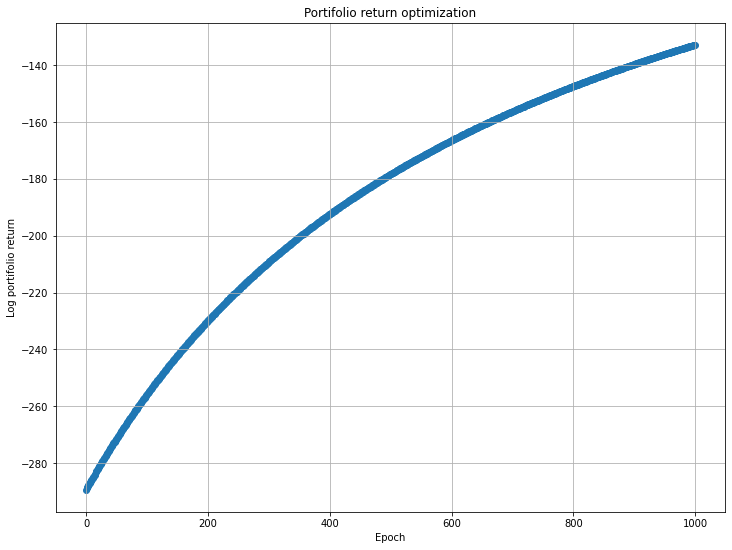

In [77]:
plt.figure(figsize=(12,9))
# plt.yscale('linear')
plt.scatter(x=range(len(return_all)), y=return_all)
plt.title('Portifolio return optimization')
plt.ylabel('Log portifolio return')
plt.xlabel('Epoch')
plt.grid()
plt.show()

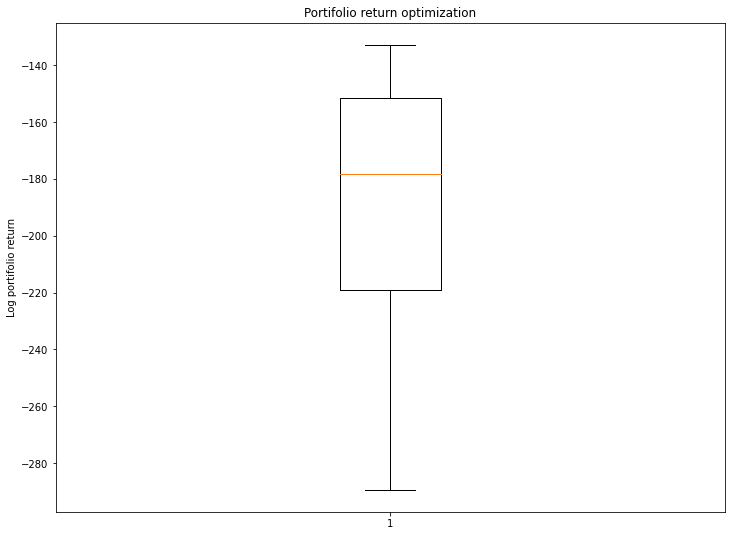

In [78]:
plt.figure(figsize=(12,9))
# plt.yscale('linear')
plt.boxplot(return_all)
plt.title('Portifolio return optimization')
plt.ylabel('Log portifolio return')
plt.show()

In [ ]:


# benchmark portifolio weight of stock i on time t
w_i_t_bench = 1.0

# weight of stock i on time t
w_i_t = w_i_t_bench + (1/number_of_stocks)*X.dot(firm_characteristics)

# Where X is a vector of coefficients that we want to find and firm_characteristics are a vector of firm characteristics.
